In [9]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

# Define the Stan model
stan_model_code = """
data {
    int<lower=0> N;
    vector[N] y;
}
parameters {
    real mu;
}
model {
    y ~ normal(mu, 1.0);
}
"""
stan_model_code = """
data {
    int<lower=0> N;  // number of trials
    array[N] int<lower=0, upper=1> y;  // observed data
    real<lower=0> alpha;  // prior hyperparameter
    real<lower=0> beta;  // prior hyperparameter
}
parameters {
    real<lower=0, upper=1> theta;  // parameter of interest
}
model {
    theta ~ beta(alpha, beta);  // prior distribution
    y ~ bernoulli(theta);  // likelihood
}
"""
# Write the Stan model to a file
import os
dirname = './compiled'
os.makedirs(dirname, exist_ok=True)

stan_file = dirname + '/model.stan'
print(f'Writing Stan model to {stan_file}')
with open(stan_file, 'w') as f:
    f.write(stan_model_code)


Writing Stan model to ./compiled/model.stan


In [10]:
# Compile the Stan model
stan_model = CmdStanModel(stan_file=stan_file)

22:55:46 - cmdstanpy - INFO - compiling stan file E:\git\KOS6313\compiled\model.stan to exe file E:\git\KOS6313\compiled\model.exe
22:56:04 - cmdstanpy - INFO - compiled model executable: E:\git\KOS6313\compiled\model.exe


In [61]:
# Generate some synthetic data
np.random.seed(1)
N = 100
y = np.random.normal(0, 1, N)

y = np.array([-2., -1., 0., 1., 2.])
N = len(y)
# Prepare data for Stan
data = {'N': N, 'y': y}

# Find the MAP estimate using CmdStanPy's optimize method
map_estimate = stan_model.optimize(data=data)

print("MAP estimate of mu:", map_estimate.stan_variable('mu'))

13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:48:26 - cmdstanpy - INFO - Chain [1] done processing
13:48:26 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


MAP estimate of mu: 0.0


MAP estimate of mu: -0.04040404040404022


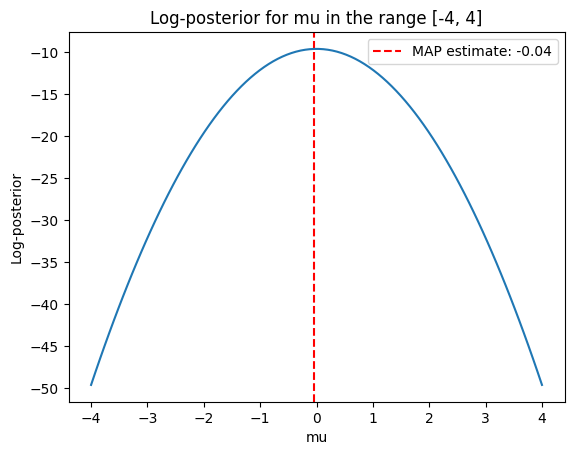

In [62]:
# Define the log-posterior function
def log_posterior(mu, y):
    sigma = 1.0
    N = len(y)
    return -0.5 * N * np.log(2 * np.pi * sigma**2) - np.sum((y - mu)**2) / (2 * sigma**2)

# Plot the log-posterior for mu in the range [-4, 4]
mu_values = np.linspace(-4, 4, 100)
log_posterior_values = [log_posterior(mu, y) for mu in mu_values]

lp_max = np.max(log_posterior_values), 
lp_max_index = np.argmax(log_posterior_values)
lp_map = mu_values[lp_max_index]
print("MAP estimate of mu:", lp_map)

plt.figure()
plt.axvline(x=lp_map, color='r', linestyle='--', label=f'MAP estimate: {lp_map:.2f}')
plt.legend()
plt.plot(mu_values, log_posterior_values)
plt.xlabel('mu')
plt.ylabel('Log-posterior')
plt.title('Log-posterior for mu in the range [-4, 4]')
plt.show()

In [63]:
# Sample from the posterior distribution
posterior_samples = stan_model.sample(data=data, iter_sampling=1000, iter_warmup=500, chains=4)

# Extract the samples for mu
mu_samples = posterior_samples.stan_variable('mu')

print("Posterior samples of mu:", mu_samples)
print("mean of the posterior samples:", np.mean(mu_samples))

13:48:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▌         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


13:48:48 - cmdstanpy - INFO - CmdStan done processing.



Posterior samples of mu: [ 0.586102   0.594019  -0.121205  ...  0.129619   0.129346   0.0970154]
mean of the posterior samples: 0.009923365330875003


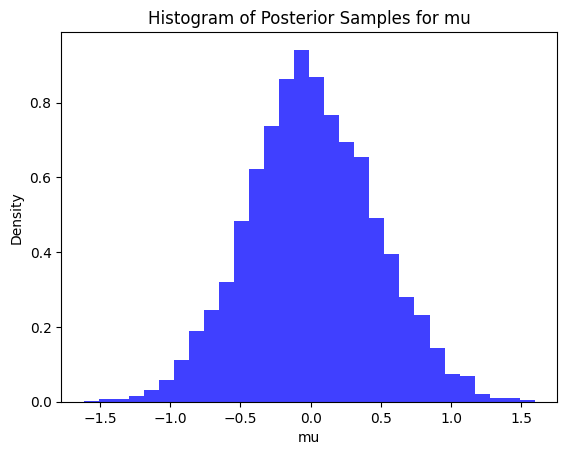

In [64]:
plt.figure()
plt.hist(mu_samples, bins=30, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')
plt.ylabel('Density')
plt.title('Histogram of Posterior Samples for mu')
plt.show()

In [65]:
num_samples = posterior_samples.num_draws_sampling
print("Number of samples in posterior_samples:", num_samples)

Number of samples in posterior_samples: 1000


In [66]:
posterior_samples_summary = posterior_samples.summary()
print(posterior_samples_summary)

          Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__ -5.514540  0.017216  0.723011  0.321517 -6.966850 -5.235410 -5.001940   
mu    0.009923  0.011135  0.453618  0.457231 -0.744377 -0.006615  0.771568   

      ESS_bulk  ESS_tail    R_hat  
lp__   2156.78   2166.56  1.00010  
mu     1666.04   2070.06  1.00053  


In [67]:
type(posterior_samples)

cmdstanpy.stanfit.mcmc.CmdStanMCMC

In [68]:
print(posterior_samples.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [69]:
?posterior_samples

Type:           CmdStanMCMC
String form:   
CmdStanMCMC: model=model chains=4['method=sample', 'num_samples=1000', 'num_warmup=500', 'algorit <...> .txt
           C:\Users\VIP\AppData\Local\Temp\tmppmxw8ixi\modelijf2pre8\model-20250303134848_3-stdout.txt
File:           e:\git\kos6313\.venv\lib\site-packages\cmdstanpy\stanfit\mcmc.py
Docstring:     
Container for outputs from CmdStan sampler run.
Provides methods to summarize and diagnose the model fit
and accessor methods to access the entire sample or
individual items. Created by :meth:`CmdStanModel.sample`

The sample is lazily instantiated on first access of either
the resulting sample or the HMC tuning parameters, i.e., the
step size and metric.
Init docstring: Initialize object.

In [70]:
ps = posterior_samples
ps.draws().shape, ps.draws_pd().shape

((1000, 4, 8), (4000, 11))

In [71]:
ps.draws_pd().head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu
0,1.0,1.0,1.0,-5.85879,0.747808,1.28975,1.0,1.0,0.0,5.86185,0.586102
1,1.0,2.0,2.0,-5.88215,0.997079,1.28975,2.0,3.0,0.0,6.20294,0.594019
2,1.0,3.0,3.0,-5.03673,0.977409,1.28975,1.0,3.0,0.0,5.68220,-0.121205
3,1.0,4.0,4.0,-5.06991,0.987573,1.28975,1.0,1.0,0.0,5.08053,-0.167221
4,1.0,5.0,5.0,-5.35795,0.910660,1.28975,2.0,3.0,0.0,5.54468,0.378391


In [72]:
ps.draws(concat_chains=True).shape

(4000, 8)

In [73]:
s = ps.draws(concat_chains=True)
s.shape

(4000, 8)

In [74]:
ps.draws_pd().columns

Index(['chain__', 'iter__', 'draw__', 'lp__', 'accept_stat__', 'stepsize__',
       'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'mu'],
      dtype='object')

In [75]:
ps.draws_pd().keys()

Index(['chain__', 'iter__', 'draw__', 'lp__', 'accept_stat__', 'stepsize__',
       'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'mu'],
      dtype='object')

In [76]:
s[:,-1] # last column is mu; the order is the same as the order of keywords in ps.draws_pd().columns

array([ 0.586102 ,  0.594019 , -0.121205 , ...,  0.129619 ,  0.129346 ,
        0.0970154], shape=(4000,))

Text(0.5, 0, 'mu')

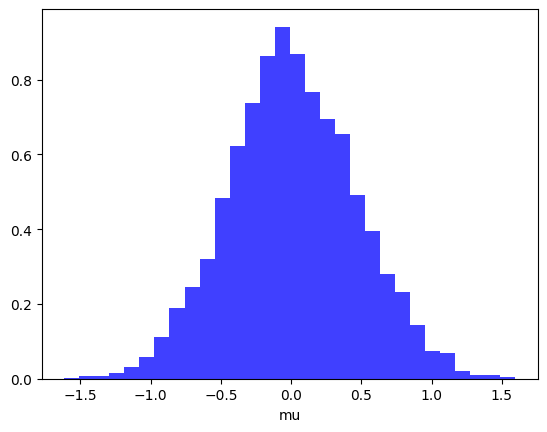

In [77]:
plt.hist(s[:,-1], bins=30, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')

Text(0.5, 0, 'mu')

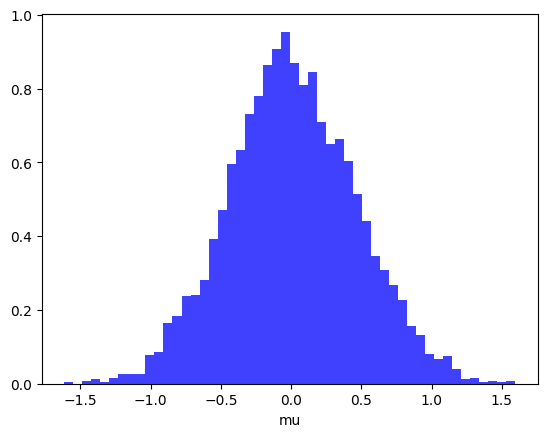

In [78]:
plt.hist(ps.draws_pd()['mu'], bins=50, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')

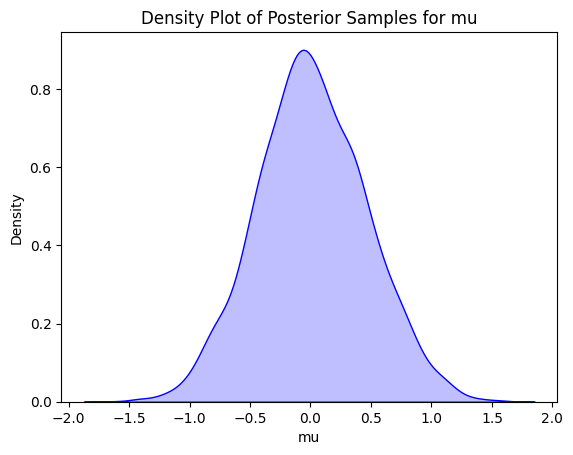

In [79]:
import seaborn as sns

plt.figure()
sns.kdeplot(mu_samples, fill=True, color='blue')
plt.xlabel('mu')
plt.ylabel('Density')
plt.title('Density Plot of Posterior Samples for mu')
plt.show()

End.